In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal

In [2]:
def detect_edges(im, fn):    
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    mag = fn(gray)
    
    return mag

def compute_edges_dxdy(I):
    """Returns the norm of dx and dy as the edge response function."""
    I = I.astype(np.float32) / 255.
    dx = signal.convolve2d(I, np.array([[-1, 0, 1]]), mode='same')
    dy = signal.convolve2d(I, np.array([[-1, 0, 1]]).T, mode='same')
    mag = np.sqrt(dx ** 2 + dy ** 2)
    mag = mag / np.max(mag)
    mag = mag * 255.
    mag = np.clip(mag, 0, 255)
    mag = mag.astype(np.uint8)
    
    return mag

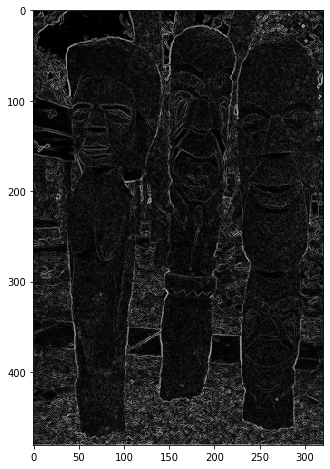

In [3]:
img = plt.imread("101085.jpg")

plt.figure(figsize=(10,8))
plt.imshow(detect_edges(img, compute_edges_dxdy), cmap='gray')

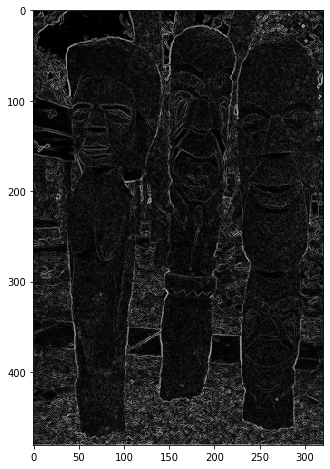

In [15]:
img = plt.imread("101085.jpg")
# img = cv2.GaussianBlur(img, (7,7), 0)

plt.figure(figsize=(10,8))
plt.imshow(detect_edges(img, compute_edges_dxdy), cmap='gray')

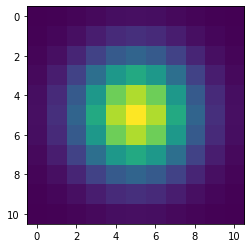

In [16]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

plt.imshow(gaussian_kernel(10, sigma=2))
g = gaussian_kernel(10, sigma=2)

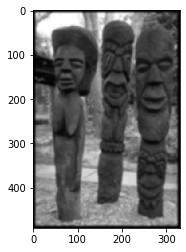

In [17]:

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
blur = signal.convolve2d(gray, g)
plt.imshow(blur, cmap='gray')

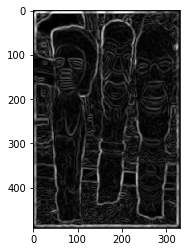

In [18]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

G, theta = (sobel_filters(blur))
plt.imshow(G, cmap='gray')

In [19]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

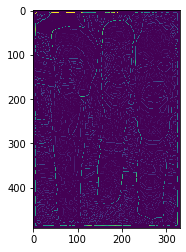

In [20]:
Z = non_max_suppression(G, theta)
plt.imshow(Z)

In [21]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

res, weak, strong = threshold(Z)

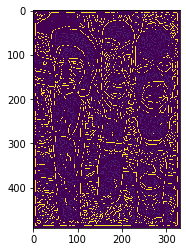

In [22]:
plt.imshow(res)
# plt.imshow(strong)

In [23]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

woah = hysteresis(res, weak)

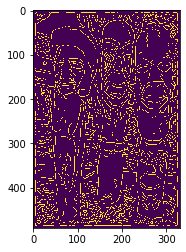

In [24]:
plt.imshow(woah)